In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mygrad import sliding_window_view

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, Dropout, LSTM
import tensorflow as tf

%matplotlib notebook

Functions from POMS_sentiment used to load existing dictionary

In [3]:
def load_sent_dict(path="sent_dict.txt"):
    with open(path, "rb") as f:
        return pickle.load(f)

def save_sent_dict(sent_dict, path="sent_dict.txt"):
    with open(path, "wb") as f:
        pickle.dump(sent_dict, f, pickle.HIGHEST_PROTOCOL)

def sentiment_time_series(sent_dict, key):
    N = max(sent_dict.keys())
    
    T = np.ndarray((N,))
    for i in range(N):
        T[i] = sent_dict[i][key]
        
    #convert to z-scores
    mean = np.mean(T)
    std  = np.std(T)
    T = (T - mean) / std
        
    return T

In [4]:
sent_dict = load_sent_dict(path="sent_dict.txt")

Functions from DJIA_preprocess used to load DJIA data

In [5]:
def load_djia(path="djia_ts.txt"):
    with open(path, "rb") as f:
        return pickle.load(f)

def save_djia(ts, path="djia_ts.txt"):
    with open(path, "wb") as f:
        pickle.dump(ts, f, pickle.HIGHEST_PROTOCOL)

In [63]:
djia = load_djia(path="djia_ts.txt")

Load in relevant part of the DJIA data for training, zscore it, and create time series for Calm and Happy

In [99]:
train_djia = djia[130:130+98]
#train_djia = djia[:98]
train_djia = (train_djia - np.mean(train_djia)) / np.std(train_djia)

In [173]:
calm = -sentiment_time_series(sent_dict, "tension") - sentiment_time_series(sent_dict, "anger")
happy = sentiment_time_series(sent_dict, "vigour") - sentiment_time_series(sent_dict, "depression")
alert = -sentiment_time_series(sent_dict, "fatigue") - sentiment_time_series(sent_dict, "confusion")

dfft = np.fft.fft(calm)
dfft[30:] = 0
calm = np.real(np.fft.ifft(dfft))

dfft = np.fft.fft(happy)
dfft[30:] = 0
happy = np.real(np.fft.ifft(dfft))

dfft = np.fft.fft(alert)
dfft[30:] = 0
alert = np.real(np.fft.ifft(dfft))

This function creates a dataset by looking at "windows" of previous time series values. In other words, we're trying to predict a stock value on each day by looking at sentiment data in the past $N$ days. Obviously this means we can't do predictions for the first $N$ days which makes sense.

Experiment: to augment time series data with previous returns, you could attempt to pass DJIA data to this function as well as other time series.

We can then easily generate our training data using a call of this function.

In [101]:
def windowed_data(window_size, *ts_data):
    k = window_size * len(ts_data)
    dataset = np.ndarray((len(ts_data[0]) - window_size + 1, k))
    
    for i, ts in enumerate(ts_data):
        dataset[:,window_size*i:window_size*(i+1)] = sliding_window_view(ts, (window_size,), 1)
    
    return dataset[:-1]

In [121]:
N = 3
x_train = windowed_data(N+1, calm, happy, alert)
y_train = train_djia[N:-1]
x_train.shape, y_train.shape

((94, 12), (94,))

This function will test any of our prediction algorithms by a simple cross validation.

In [122]:
def cross_validate_model(k, x_data, y_data, model):
    size = int(len(x_data) / k)
    
    prediction = np.zeros(y_data.shape)
        
    for i in range(k):
        
        if i == k-1:
            x_train = x_data[:i*size]
            y_train = y_data[:i*size]

            x_test = x_data[i*size:]
            y_test = y_data[i*size:]
            
            prediction[i*size:] = model(x_test, x_train, y_train)
        else:
            x_train = np.concatenate((x_data[:i*size], x_data[(i+1)*size:]))
            y_train = np.concatenate((y_data[:i*size], y_data[(i+1)*size:]))

            x_test = x_data[i*size:(i+1)*size]
            y_test = y_data[i*size:(i+1)*size]
        
            prediction[i*size:(i+1)*size] = model(x_test, x_train, y_train)
            
        print("Fold " + str(i) + " trained.")
        
    return prediction

def mape(truth, prediction):
    #return np.abs(truth - prediction)
    return np.mean(np.abs((truth - prediction) / truth))

def rmse(truth, prediction):
    return np.sqrt(np.mean((truth - prediction) ** 2))

def accuracy(truth, prediction, lag):
    length = len(truth)
    correct = 0.0
    for i in range(lag,length):
        lastTruth = np.mean(truth[i-lag:i])
        lastPred  = np.mean(prediction[i-lag:i])
        if (truth[i] >= lastTruth and prediction[i] >= lastPred):
            correct += 1
        elif (truth[i] <= lastTruth and prediction[i] <= lastPred):
            correct += 1
    
    return correct / (length - lag)

Our first (very simple) prediction algorithm: linear regression

In [123]:
def linreg_prediction(A, x_train, y_train):
    factor = np.linalg.lstsq(x_train, y_train, rcond=None)[0]
    return np.matmul(A, factor)

<IPython.core.display.Javascript object>


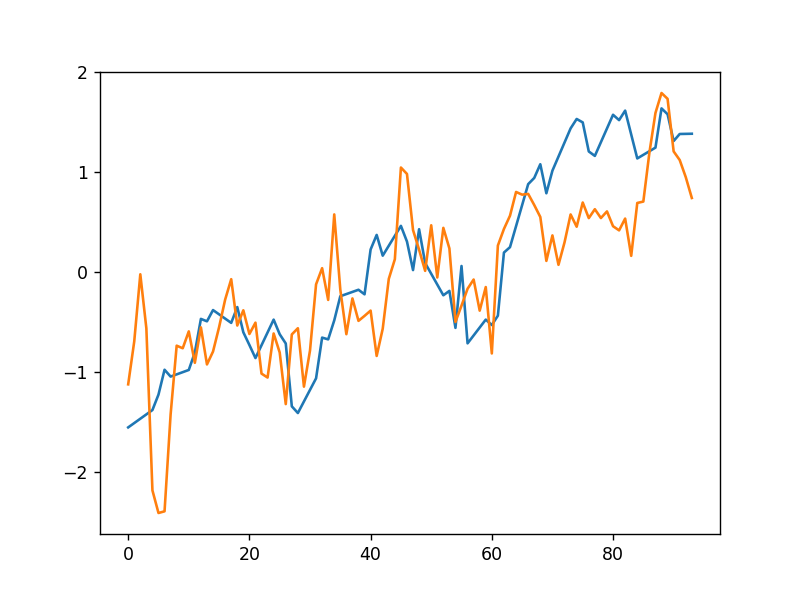

Fold 0 trained.
Fold 1 trained.
Fold 2 trained.
Fold 3 trained.
Fold 4 trained.


In [224]:
fig, ax = plt.subplots()
ax.plot(y_train)
ax.plot(cross_validate_model(5, x_train, y_train, linreg_prediction))

In [225]:
linear_output = cross_validate_model(5, x_train, y_train, linreg_prediction)
rmse(y_train, linear_output), accuracy(y_train, linear_output, 1)

Fold 0 trained.
Fold 1 trained.
Fold 2 trained.
Fold 3 trained.
Fold 4 trained.


(0.6062754330506491, 0.5483870967741935)

Model for a dense neural network with 3 sigmoid layers.

In [126]:
model = Sequential()
model.add(Dense(128, input_shape=((1+N)*3,), activation="sigmoid"))
model.add(Dense(32, activation="sigmoid"))
model.add(Dense(16, activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="linear"))

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [127]:
history = model.fit(x_train, y_train, epochs=300, batch_size=20, verbose=1, validation_split=0.2)

Train on 75 samples, validate on 19 samples
Epoch 1/300
75/75 [==============================] - 6s 78ms/step - loss: 1.2759 - mean_squared_error: 1.2759 - mean_absolute_error: 0.9325 - val_loss: 3.4669 - val_mean_squared_error: 3.4669 - val_mean_absolute_error: 1.8553
Epoch 2/300
75/75 [==============================] - 0s 439us/step - loss: 1.3105 - mean_squared_error: 1.3105 - mean_absolute_error: 0.9619 - val_loss: 3.0899 - val_mean_squared_error: 3.0899 - val_mean_absolute_error: 1.7506
Epoch 3/300
75/75 [==============================] - 0s 465us/step - loss: 1.0281 - mean_squared_error: 1.0281 - mean_absolute_error: 0.8231 - val_loss: 2.8464 - val_mean_squared_error: 2.8464 - val_mean_absolute_error: 1.6795
Epoch 4/300
75/75 [==============================] - 0s 412us/step - loss: 1.1173 - mean_squared_error: 1.1173 - mean_absolute_error: 0.8558 - val_loss: 2.7091 - val_mean_squared_error: 2.7091 - val_mean_absolute_error: 1.6381
Epoch 5/300
75/75 [==============================

Epoch 37/300
75/75 [==============================] - 0s 359us/step - loss: 0.5644 - mean_squared_error: 0.5644 - mean_absolute_error: 0.6120 - val_loss: 2.0322 - val_mean_squared_error: 2.0322 - val_mean_absolute_error: 1.4134
Epoch 38/300
75/75 [==============================] - 0s 412us/step - loss: 0.6042 - mean_squared_error: 0.6042 - mean_absolute_error: 0.6151 - val_loss: 2.0265 - val_mean_squared_error: 2.0265 - val_mean_absolute_error: 1.4112
Epoch 39/300
75/75 [==============================] - 0s 306us/step - loss: 0.6083 - mean_squared_error: 0.6083 - mean_absolute_error: 0.6232 - val_loss: 2.0460 - val_mean_squared_error: 2.0460 - val_mean_absolute_error: 1.4179
Epoch 40/300
75/75 [==============================] - 0s 346us/step - loss: 0.5799 - mean_squared_error: 0.5799 - mean_absolute_error: 0.6126 - val_loss: 2.0713 - val_mean_squared_error: 2.0713 - val_mean_absolute_error: 1.4266
Epoch 41/300
75/75 [==============================] - 0s 399us/step - loss: 0.5970 - mea

Epoch 73/300
75/75 [==============================] - 0s 306us/step - loss: 0.3191 - mean_squared_error: 0.3191 - mean_absolute_error: 0.4348 - val_loss: 1.2177 - val_mean_squared_error: 1.2177 - val_mean_absolute_error: 1.0769
Epoch 74/300
75/75 [==============================] - 0s 332us/step - loss: 0.2974 - mean_squared_error: 0.2974 - mean_absolute_error: 0.4401 - val_loss: 1.1617 - val_mean_squared_error: 1.1617 - val_mean_absolute_error: 1.0505
Epoch 75/300
75/75 [==============================] - 0s 332us/step - loss: 0.3777 - mean_squared_error: 0.3777 - mean_absolute_error: 0.4991 - val_loss: 1.1324 - val_mean_squared_error: 1.1324 - val_mean_absolute_error: 1.0359
Epoch 76/300
75/75 [==============================] - 0s 366us/step - loss: 0.3112 - mean_squared_error: 0.3112 - mean_absolute_error: 0.4535 - val_loss: 1.1137 - val_mean_squared_error: 1.1137 - val_mean_absolute_error: 1.0264
Epoch 77/300
75/75 [==============================] - 0s 372us/step - loss: 0.3523 - mea

Epoch 109/300
75/75 [==============================] - 0s 319us/step - loss: 0.2809 - mean_squared_error: 0.2809 - mean_absolute_error: 0.4229 - val_loss: 0.8959 - val_mean_squared_error: 0.8959 - val_mean_absolute_error: 0.9114
Epoch 110/300
75/75 [==============================] - 0s 545us/step - loss: 0.3056 - mean_squared_error: 0.3056 - mean_absolute_error: 0.4196 - val_loss: 0.8837 - val_mean_squared_error: 0.8837 - val_mean_absolute_error: 0.9047
Epoch 111/300
75/75 [==============================] - 0s 439us/step - loss: 0.2658 - mean_squared_error: 0.2658 - mean_absolute_error: 0.4001 - val_loss: 0.8731 - val_mean_squared_error: 0.8731 - val_mean_absolute_error: 0.8989
Epoch 112/300
75/75 [==============================] - 0s 412us/step - loss: 0.2770 - mean_squared_error: 0.2770 - mean_absolute_error: 0.4167 - val_loss: 0.8847 - val_mean_squared_error: 0.8847 - val_mean_absolute_error: 0.9052
Epoch 113/300
75/75 [==============================] - 0s 412us/step - loss: 0.2594 

75/75 [==============================] - 0s 386us/step - loss: 0.2155 - mean_squared_error: 0.2155 - mean_absolute_error: 0.3797 - val_loss: 0.7556 - val_mean_squared_error: 0.7556 - val_mean_absolute_error: 0.8280
Epoch 145/300
75/75 [==============================] - 0s 386us/step - loss: 0.2514 - mean_squared_error: 0.2514 - mean_absolute_error: 0.4111 - val_loss: 0.7446 - val_mean_squared_error: 0.7446 - val_mean_absolute_error: 0.8206
Epoch 146/300
75/75 [==============================] - 0s 386us/step - loss: 0.3097 - mean_squared_error: 0.3097 - mean_absolute_error: 0.4327 - val_loss: 0.7588 - val_mean_squared_error: 0.7588 - val_mean_absolute_error: 0.8285
Epoch 147/300
75/75 [==============================] - 0s 412us/step - loss: 0.2315 - mean_squared_error: 0.2315 - mean_absolute_error: 0.3886 - val_loss: 0.7748 - val_mean_squared_error: 0.7748 - val_mean_absolute_error: 0.8376
Epoch 148/300
75/75 [==============================] - 0s 359us/step - loss: 0.2530 - mean_squared

Epoch 180/300
75/75 [==============================] - 0s 731us/step - loss: 0.3013 - mean_squared_error: 0.3013 - mean_absolute_error: 0.4350 - val_loss: 0.7854 - val_mean_squared_error: 0.7854 - val_mean_absolute_error: 0.8482
Epoch 181/300
75/75 [==============================] - 0s 412us/step - loss: 0.2114 - mean_squared_error: 0.2114 - mean_absolute_error: 0.3657 - val_loss: 0.7567 - val_mean_squared_error: 0.7567 - val_mean_absolute_error: 0.8317
Epoch 182/300
75/75 [==============================] - 0s 505us/step - loss: 0.2312 - mean_squared_error: 0.2312 - mean_absolute_error: 0.3705 - val_loss: 0.7338 - val_mean_squared_error: 0.7338 - val_mean_absolute_error: 0.8174
Epoch 183/300
75/75 [==============================] - 0s 412us/step - loss: 0.2515 - mean_squared_error: 0.2515 - mean_absolute_error: 0.3981 - val_loss: 0.7349 - val_mean_squared_error: 0.7349 - val_mean_absolute_error: 0.8175
Epoch 184/300
75/75 [==============================] - 0s 486us/step - loss: 0.2462 

Epoch 216/300
75/75 [==============================] - 0s 386us/step - loss: 0.2334 - mean_squared_error: 0.2334 - mean_absolute_error: 0.3669 - val_loss: 0.7302 - val_mean_squared_error: 0.7302 - val_mean_absolute_error: 0.8104
Epoch 217/300
75/75 [==============================] - 0s 366us/step - loss: 0.2790 - mean_squared_error: 0.2790 - mean_absolute_error: 0.3977 - val_loss: 0.7226 - val_mean_squared_error: 0.7226 - val_mean_absolute_error: 0.8059
Epoch 218/300
75/75 [==============================] - 0s 332us/step - loss: 0.2435 - mean_squared_error: 0.2435 - mean_absolute_error: 0.3632 - val_loss: 0.7219 - val_mean_squared_error: 0.7219 - val_mean_absolute_error: 0.8051
Epoch 219/300
75/75 [==============================] - 0s 412us/step - loss: 0.2067 - mean_squared_error: 0.2067 - mean_absolute_error: 0.3612 - val_loss: 0.7221 - val_mean_squared_error: 0.7221 - val_mean_absolute_error: 0.8044
Epoch 220/300
75/75 [==============================] - 0s 451us/step - loss: 0.2154 

Epoch 252/300
75/75 [==============================] - 0s 346us/step - loss: 0.2407 - mean_squared_error: 0.2407 - mean_absolute_error: 0.3962 - val_loss: 0.7655 - val_mean_squared_error: 0.7655 - val_mean_absolute_error: 0.8326
Epoch 253/300
75/75 [==============================] - 0s 346us/step - loss: 0.2193 - mean_squared_error: 0.2193 - mean_absolute_error: 0.3801 - val_loss: 0.7479 - val_mean_squared_error: 0.7479 - val_mean_absolute_error: 0.8221
Epoch 254/300
75/75 [==============================] - 0s 386us/step - loss: 0.1793 - mean_squared_error: 0.1793 - mean_absolute_error: 0.3444 - val_loss: 0.7225 - val_mean_squared_error: 0.7225 - val_mean_absolute_error: 0.8069
Epoch 255/300
75/75 [==============================] - 0s 412us/step - loss: 0.2254 - mean_squared_error: 0.2254 - mean_absolute_error: 0.3734 - val_loss: 0.7207 - val_mean_squared_error: 0.7207 - val_mean_absolute_error: 0.8060
Epoch 256/300
75/75 [==============================] - 0s 412us/step - loss: 0.2168 

Epoch 288/300
75/75 [==============================] - 0s 399us/step - loss: 0.2384 - mean_squared_error: 0.2384 - mean_absolute_error: 0.3654 - val_loss: 0.7465 - val_mean_squared_error: 0.7465 - val_mean_absolute_error: 0.8196
Epoch 289/300
75/75 [==============================] - 0s 346us/step - loss: 0.2344 - mean_squared_error: 0.2344 - mean_absolute_error: 0.3834 - val_loss: 0.7434 - val_mean_squared_error: 0.7434 - val_mean_absolute_error: 0.8175
Epoch 290/300
75/75 [==============================] - 0s 399us/step - loss: 0.1690 - mean_squared_error: 0.1690 - mean_absolute_error: 0.3390 - val_loss: 0.7350 - val_mean_squared_error: 0.7350 - val_mean_absolute_error: 0.8119
Epoch 291/300
75/75 [==============================] - 0s 439us/step - loss: 0.1919 - mean_squared_error: 0.1919 - mean_absolute_error: 0.3349 - val_loss: 0.7379 - val_mean_squared_error: 0.7379 - val_mean_absolute_error: 0.8139
Epoch 292/300
75/75 [==============================] - 0s 346us/step - loss: 0.2058 

<IPython.core.display.Javascript object>


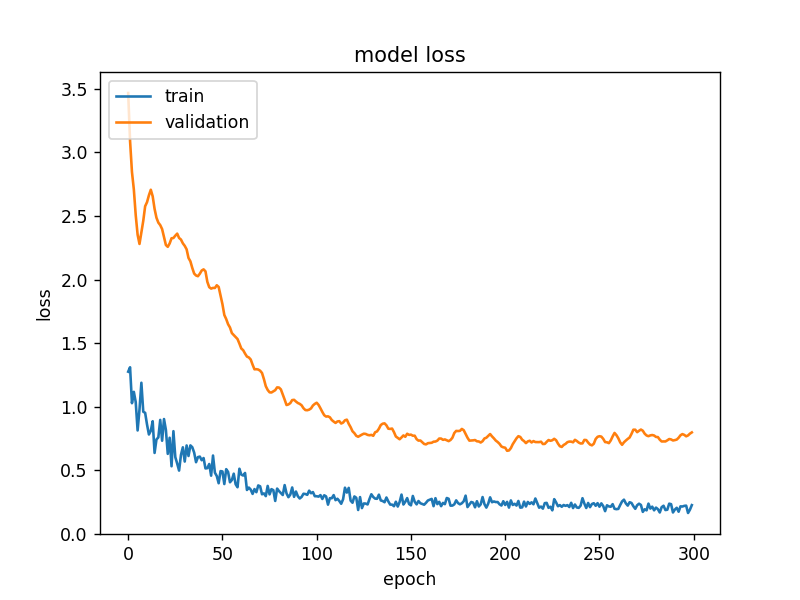

In [128]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [129]:
def dense_prediction(A, x_train, y_train):
    model = Sequential()
    model.add(Dense(512, input_shape=(3*(N+1),), activation="sigmoid"))
    model.add(Dense(512, activation="sigmoid"))
    model.add(Dense(1, activation="linear"))

    model.compile(loss='mse', optimizer='adagrad', metrics=['mse', 'mae'])
    model.fit(x_train, y_train, epochs=300, batch_size=10, verbose=0)
    
    return model.predict(A).flatten()

In [130]:
dense_output = cross_validate_model(5, x_train, y_train, dense_prediction)

Fold 0 trained.
Fold 1 trained.
Fold 2 trained.
Fold 3 trained.
Fold 4 trained.


<IPython.core.display.Javascript object>


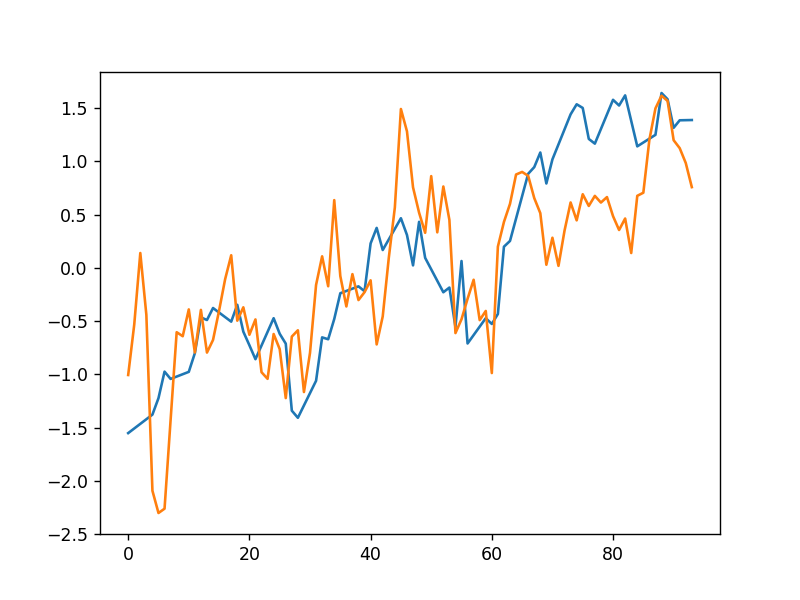

In [131]:
fig, ax = plt.subplots()
ax.plot(y_train)

ax.plot(dense_output)
#ax.plot(np.random.rand(94))

In [133]:
rmse(y_train, dense_output), accuracy(y_train, dense_output, 1)

(0.6329879118824862, 0.5483870967741935)

Finally, we'll use a *recurrent* neural network for our last type of model. In particular we'll use a long-short term memory network or LSTM with 256 filters. This requires a slightly different windowed data function, but trains in much the same way as the dense network.

In [174]:
def windowed_data_lstm(window_size, *ts_data):
    dataset = np.ndarray((len(ts_data[0]) - window_size + 1, window_size, len(ts_data)))
    
    for i, ts in enumerate(ts_data):
        dataset[:,:,i] = sliding_window_view(ts, (window_size,), 1)
    
    return dataset

In [175]:
x_train_lstm = windowed_data_lstm(7, calm, happy, alert)
y_train_lstm = train_djia[6:]

In [176]:
model = Sequential()
model.add(LSTM(256, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(loss='mse', optimizer='rmsprop', metrics=['mse', 'mae'])

In [140]:
history = model.fit(x_train_lstm, y_train, epochs=500, batch_size=5, verbose=1, validation_split=0.2)

Train on 75 samples, validate on 19 samples
Epoch 1/500
75/75 [==============================] - ETA: 0s - loss: 0.3708 - mean_squared_error: 0.3708 - mean_absolute_error: 0.48 - 2s 22ms/step - loss: 0.3618 - mean_squared_error: 0.3618 - mean_absolute_error: 0.4748 - val_loss: 0.7475 - val_mean_squared_error: 0.7475 - val_mean_absolute_error: 0.7505
Epoch 2/500
75/75 [==============================] - 0s 5ms/step - loss: 0.2166 - mean_squared_error: 0.2166 - mean_absolute_error: 0.3598 - val_loss: 0.6654 - val_mean_squared_error: 0.6654 - val_mean_absolute_error: 0.6933
Epoch 3/500
75/75 [==============================] - 0s 4ms/step - loss: 0.2109 - mean_squared_error: 0.2109 - mean_absolute_error: 0.3644 - val_loss: 0.6658 - val_mean_squared_error: 0.6658 - val_mean_absolute_error: 0.6944
Epoch 4/500
75/75 [==============================] - 0s 4ms/step - loss: 0.1702 - mean_squared_error: 0.1702 - mean_absolute_error: 0.3355 - val_loss: 0.6246 - val_mean_squared_error: 0.6246 - val_m

Epoch 37/500
75/75 [==============================] - 0s 5ms/step - loss: 0.0312 - mean_squared_error: 0.0312 - mean_absolute_error: 0.1339 - val_loss: 0.3799 - val_mean_squared_error: 0.3799 - val_mean_absolute_error: 0.5131
Epoch 38/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0316 - mean_squared_error: 0.0316 - mean_absolute_error: 0.1379 - val_loss: 0.3993 - val_mean_squared_error: 0.3993 - val_mean_absolute_error: 0.4988
Epoch 39/500
75/75 [==============================] - 0s 5ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1260 - val_loss: 0.4062 - val_mean_squared_error: 0.4062 - val_mean_absolute_error: 0.5019
Epoch 40/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_error: 0.1357 - val_loss: 0.4988 - val_mean_squared_error: 0.4988 - val_mean_absolute_error: 0.6030
Epoch 41/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0230 - mean_squared_

75/75 [==============================] - 0s 4ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0866 - val_loss: 0.7240 - val_mean_squared_error: 0.7240 - val_mean_absolute_error: 0.7362
Epoch 74/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0867 - val_loss: 0.6066 - val_mean_squared_error: 0.6066 - val_mean_absolute_error: 0.6831
Epoch 75/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0741 - val_loss: 0.3527 - val_mean_squared_error: 0.3527 - val_mean_absolute_error: 0.4635
Epoch 76/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0959 - val_loss: 0.4539 - val_mean_squared_error: 0.4539 - val_mean_absolute_error: 0.5868
Epoch 77/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0132 - mean_squared_error: 0.0132

75/75 [==============================] - 0s 4ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0662 - val_loss: 0.5402 - val_mean_squared_error: 0.5402 - val_mean_absolute_error: 0.6062
Epoch 110/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0625 - val_loss: 0.3764 - val_mean_squared_error: 0.3764 - val_mean_absolute_error: 0.4786
Epoch 111/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0541 - val_loss: 0.5718 - val_mean_squared_error: 0.5718 - val_mean_absolute_error: 0.5931
Epoch 112/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0694 - val_loss: 0.4095 - val_mean_squared_error: 0.4095 - val_mean_absolute_error: 0.4884
Epoch 113/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0050 - mean_squared_error: 0.

75/75 [==============================] - 0s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0444 - val_loss: 0.4184 - val_mean_squared_error: 0.4184 - val_mean_absolute_error: 0.4877
Epoch 146/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0662 - val_loss: 0.4212 - val_mean_squared_error: 0.4212 - val_mean_absolute_error: 0.4825
Epoch 147/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0484 - val_loss: 0.3556 - val_mean_squared_error: 0.3556 - val_mean_absolute_error: 0.4331
Epoch 148/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0538 - val_loss: 0.3772 - val_mean_squared_error: 0.3772 - val_mean_absolute_error: 0.4578
Epoch 149/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0046 - mean_squared_error: 0.

75/75 [==============================] - 0s 4ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0430 - val_loss: 0.3999 - val_mean_squared_error: 0.3999 - val_mean_absolute_error: 0.4670
Epoch 182/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0438 - val_loss: 0.3820 - val_mean_squared_error: 0.3820 - val_mean_absolute_error: 0.4533
Epoch 183/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0494 - val_loss: 0.3955 - val_mean_squared_error: 0.3955 - val_mean_absolute_error: 0.4681
Epoch 184/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0461 - val_loss: 0.3859 - val_mean_squared_error: 0.3859 - val_mean_absolute_error: 0.4658
Epoch 185/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0023 - mean_squared_error: 0.

75/75 [==============================] - 0s 4ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0426 - val_loss: 0.3389 - val_mean_squared_error: 0.3389 - val_mean_absolute_error: 0.4484
Epoch 218/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0355 - val_loss: 0.3519 - val_mean_squared_error: 0.3519 - val_mean_absolute_error: 0.4455
Epoch 219/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0353 - val_loss: 0.3456 - val_mean_squared_error: 0.3456 - val_mean_absolute_error: 0.4534
Epoch 220/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0454 - val_loss: 0.3757 - val_mean_squared_error: 0.3757 - val_mean_absolute_error: 0.4681
Epoch 221/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0023 - mean_squared_error: 0.

75/75 [==============================] - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0306 - val_loss: 0.3856 - val_mean_squared_error: 0.3856 - val_mean_absolute_error: 0.4717
Epoch 254/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0392 - val_loss: 0.4132 - val_mean_squared_error: 0.4132 - val_mean_absolute_error: 0.4783
Epoch 255/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0308 - val_loss: 0.4111 - val_mean_squared_error: 0.4111 - val_mean_absolute_error: 0.4996
Epoch 256/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0459 - val_loss: 0.4680 - val_mean_squared_error: 0.4680 - val_mean_absolute_error: 0.5202
Epoch 257/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.

75/75 [==============================] - 0s 5ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0396 - val_loss: 0.3787 - val_mean_squared_error: 0.3787 - val_mean_absolute_error: 0.4664
Epoch 290/500
75/75 [==============================] - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0260 - val_loss: 0.4078 - val_mean_squared_error: 0.4078 - val_mean_absolute_error: 0.4904
Epoch 291/500
75/75 [==============================] - 0s 5ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0363 - val_loss: 0.4347 - val_mean_squared_error: 0.4347 - val_mean_absolute_error: 0.4989
Epoch 292/500
75/75 [==============================] - 0s 6ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0394 - val_loss: 0.3997 - val_mean_squared_error: 0.3997 - val_mean_absolute_error: 0.4817
Epoch 293/500
75/75 [==============================] - 1s 7ms/step - loss: 0.0031 - mean_squared_error: 0.

75/75 [==============================] - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0347 - val_loss: 0.3554 - val_mean_squared_error: 0.3554 - val_mean_absolute_error: 0.4430
Epoch 326/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0316 - val_loss: 0.3658 - val_mean_squared_error: 0.3658 - val_mean_absolute_error: 0.4684
Epoch 327/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0327 - val_loss: 0.3533 - val_mean_squared_error: 0.3533 - val_mean_absolute_error: 0.4591
Epoch 328/500
75/75 [==============================] - 1s 7ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0257 - val_loss: 0.3661 - val_mean_squared_error: 0.3661 - val_mean_absolute_error: 0.4651
Epoch 329/500
75/75 [==============================] - 0s 5ms/step - loss: 0.0023 - mean_squared_error: 0.

75/75 [==============================] - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0314 - val_loss: 0.4476 - val_mean_squared_error: 0.4476 - val_mean_absolute_error: 0.5374
Epoch 362/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0282 - val_loss: 0.3776 - val_mean_squared_error: 0.3776 - val_mean_absolute_error: 0.4654
Epoch 363/500
75/75 [==============================] - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0265 - val_loss: 0.3550 - val_mean_squared_error: 0.3550 - val_mean_absolute_error: 0.4556
Epoch 364/500
75/75 [==============================] - 0s 5ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0399 - val_loss: 0.4081 - val_mean_squared_error: 0.4081 - val_mean_absolute_error: 0.4967
Epoch 365/500
75/75 [==============================] - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.

75/75 [==============================] - 0s 4ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0260 - val_loss: 0.3915 - val_mean_squared_error: 0.3915 - val_mean_absolute_error: 0.4857
Epoch 398/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0268 - val_loss: 0.3663 - val_mean_squared_error: 0.3663 - val_mean_absolute_error: 0.4740
Epoch 399/500
75/75 [==============================] - 0s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0310 - val_loss: 0.4209 - val_mean_squared_error: 0.4209 - val_mean_absolute_error: 0.4980
Epoch 400/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0326 - val_loss: 0.4351 - val_mean_squared_error: 0.4351 - val_mean_absolute_error: 0.5030
Epoch 401/500
75/75 [==============================] - 0s 5ms/step - loss: 0.0010 - mean_squared_error: 0.

75/75 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0284 - val_loss: 0.3944 - val_mean_squared_error: 0.3944 - val_mean_absolute_error: 0.5061
Epoch 434/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0280 - val_loss: 0.3715 - val_mean_squared_error: 0.3715 - val_mean_absolute_error: 0.4662
Epoch 435/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0251 - val_loss: 0.3866 - val_mean_squared_error: 0.3866 - val_mean_absolute_error: 0.4761
Epoch 436/500
75/75 [==============================] - 0s 5ms/step - loss: 7.4262e-04 - mean_squared_error: 7.4262e-04 - mean_absolute_error: 0.0215 - val_loss: 0.4064 - val_mean_squared_error: 0.4064 - val_mean_absolute_error: 0.4919
Epoch 437/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0015 - mean_squared_e

Epoch 469/500
75/75 [==============================] - 0s 6ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0261 - val_loss: 0.4036 - val_mean_squared_error: 0.4036 - val_mean_absolute_error: 0.4997
Epoch 470/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0235 - val_loss: 0.4047 - val_mean_squared_error: 0.4047 - val_mean_absolute_error: 0.5235
Epoch 471/500
75/75 [==============================] - 0s 5ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0281 - val_loss: 0.3826 - val_mean_squared_error: 0.3826 - val_mean_absolute_error: 0.4837
Epoch 472/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0319 - val_loss: 0.3937 - val_mean_squared_error: 0.3937 - val_mean_absolute_error: 0.4780
Epoch 473/500
75/75 [==============================] - 0s 4ms/step - loss: 0.0011 - mean_squ

The training for an LSTM is more volatile than for the dense network on this small dataset, as shown below.

<IPython.core.display.Javascript object>


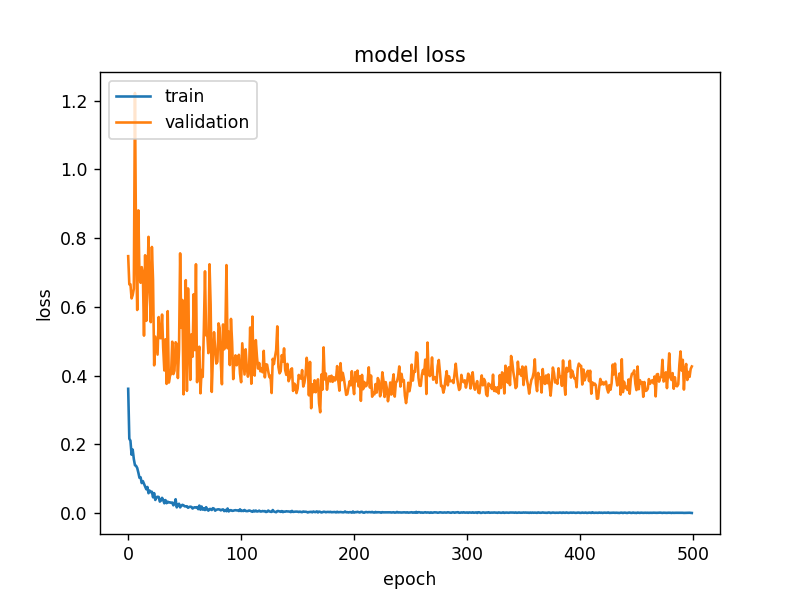

In [141]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [213]:
def lstm_prediction(A, x_train, y_train):
    model = Sequential()
    model.add(LSTM(512, activation="relu", return_sequences=True))
    model.add(LSTM(512, activation="relu"))
    model.add(Dense(1, activation="linear"))

    model.compile(loss='mse', optimizer='rmsprop', metrics=['mse', 'mae'])

    model.fit(x_train, y_train, epochs=300, batch_size=10, verbose=0)
    
    return model.predict(A).flatten()

In [214]:
lstm_output = cross_validate_model(5, x_train_lstm, y_train_lstm, lstm_prediction)

Fold 0 trained.
Fold 1 trained.
Fold 2 trained.
Fold 3 trained.
Fold 4 trained.


The LSTM obtains a better accuracy score compared to the dense network and linear regression despite comparable mean error. Thus, the LSTM is most likely the best model to use.

<IPython.core.display.Javascript object>


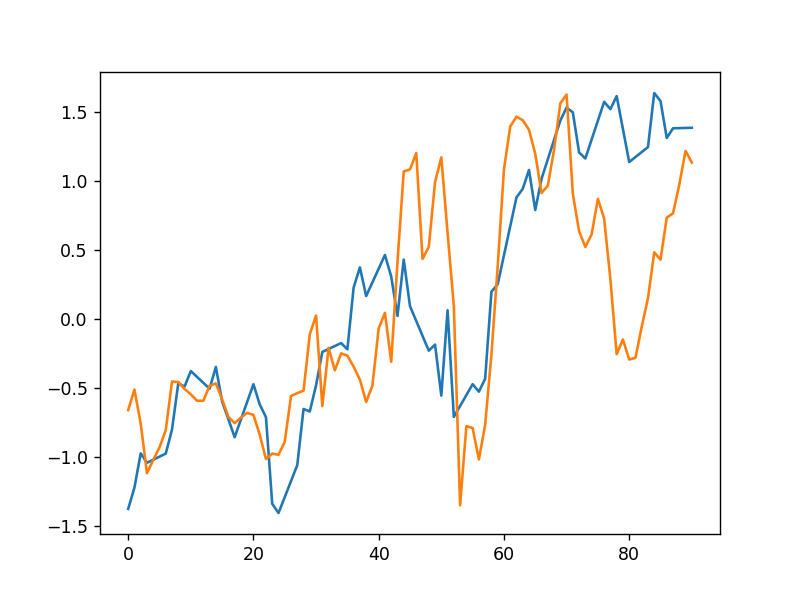

In [215]:
fig, ax = plt.subplots()
ax.plot(y_train_lstm[1:])

ax.plot(lstm_output[1:])

In [223]:
rmse(y_train_lstm, lstm_output), accuracy(y_train_lstm, lstm_output, 1)

(0.6598331751557786, 0.6923076923076923)

Now that we have all 3 models, we can plot all of the results against each other.

<IPython.core.display.Javascript object>


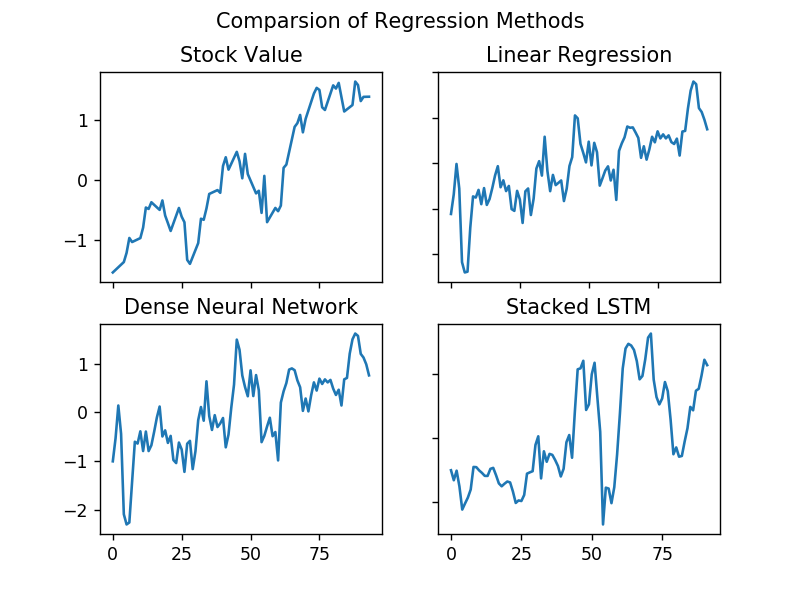

In [239]:
fig, ax = plt.subplots(nrows=2, ncols=2)

fig.suptitle("Comparsion of Regression Methods")

ax[0][0].set_title("Stock Value")
ax[0][0].plot(y_train)

ax[0][1].set_title("Linear Regression")
ax[0][1].plot(linear_output)

ax[1][0].set_title("Dense Neural Network")
ax[1][0].plot(dense_output)

ax[1][1].set_title("Stacked LSTM")
ax[1][1].plot(lstm_output)

for ax in ax.flat:
    ax.label_outer()